In [80]:
import sys
sys.path.insert(1, '/home/thomas/research/projects/a549_40x/scripts/memes/')

import warnings
warnings.filterwarnings("ignore")

import glob
import pickle
from traj_class import single_cell_traj,fluor_single_cell_traj
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

from scipy.interpolate import interp1d
from tslearn.metrics import dtw_path

In [9]:
traj_folder = 'ict-remastered-02'

main_path='/home/thomas/research/projects/a549_40x/data/'
output_path=main_path+'out/pcna/mixer/'
sct_path=output_path+'traj/'+traj_folder+'/'
sct_list=sorted(glob.glob(sct_path+'*'))
print(len(sct_list))

3


quick plot of mean intensity

In [19]:
all_traj_zero_init_time = []
all_traj_pcna_mean_int = []
for sct_idx in range(len(sct_list)):
        sct_path = sct_list[sct_idx]
        with open (sct_path, 'rb') as fp:
                sct = pickle.load(fp)
        sct_zero_init_time = sct.traj_seri[:,0]-np.min(sct.traj_seri[:,0])   # decreases initial time to 0
        sct_mean_int = sct.traj_pcna_feature_values[0]
        all_traj_zero_init_time.append(sct_zero_init_time)
        all_traj_pcna_mean_int.append(sct_mean_int)

/home/thomas/research/projects/a549_40x/data/out/pcna/mixer/traj/ict-remastered-02/ict_XY2_153-01-13-22
/home/thomas/research/projects/a549_40x/data/out/pcna/mixer/traj/ict-remastered-02/ict_XY2_179-01-13-22
/home/thomas/research/projects/a549_40x/data/out/pcna/mixer/traj/ict-remastered-02/ict_XY2_180-01-13-22


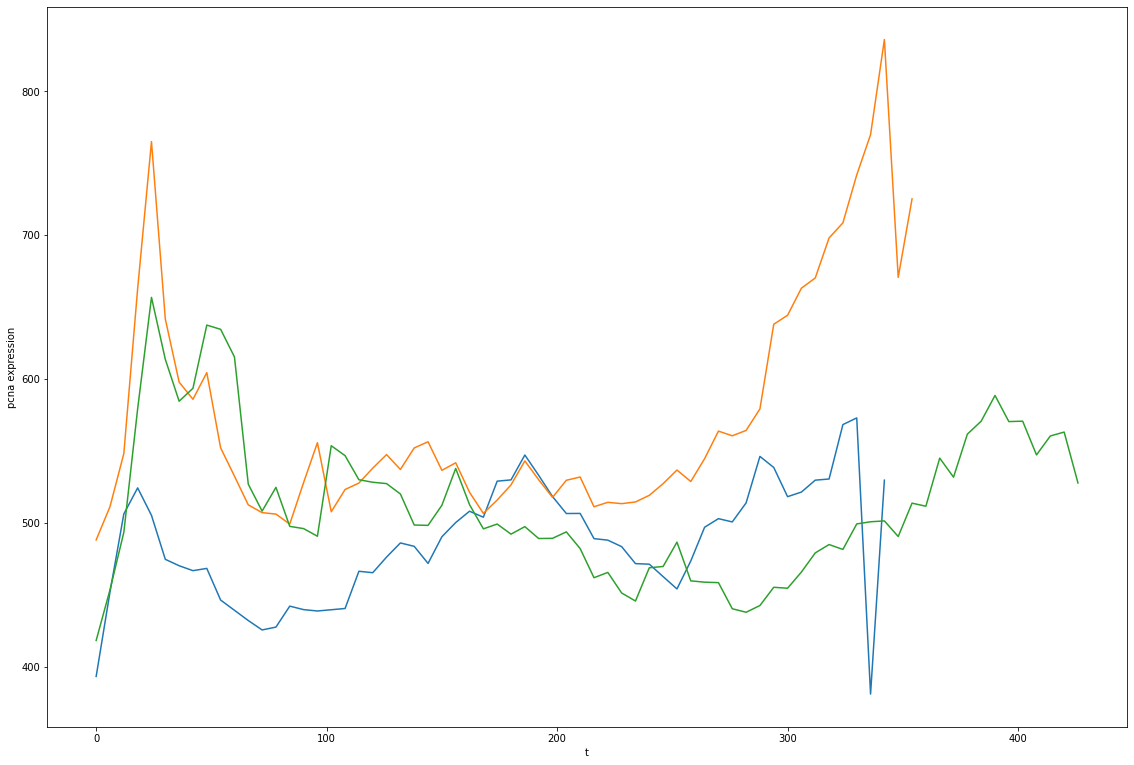

In [11]:
### plot mean intensity for all intact trajectories (cull if needed) ###
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
for sct_idx in range(len(sct_list)):
    print(sct_list[sct_idx])
    ax.plot(all_traj_zero_init_time[sct_idx],all_traj_pcna_mean_int[sct_idx])
ax.set_ylabel('pcna expression')
ax.set_xlabel('t')
# plt.savefig('filename.jpg',bbox_inches='tight', dpi=150)
plt.show()

quick plot of intensity range

In [20]:
### compute intensity range time series ###
all_traj_zero_init_time = []
all_traj_pcna_int_range = []
for sct_idx in range(len(sct_list)):
        sct_path = sct_list[sct_idx]
        with open (sct_path, 'rb') as fp:
                sct = pickle.load(fp)
        sct_zero_init_time = sct.traj_seri[:,0]-np.min(sct.traj_seri[:,0])   # decreases initial time to 0
        sct_int_range = sct.traj_pcna_feature_values[2]
        all_traj_zero_init_time.append(sct_zero_init_time)
        all_traj_pcna_int_range.append(sct_int_range)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


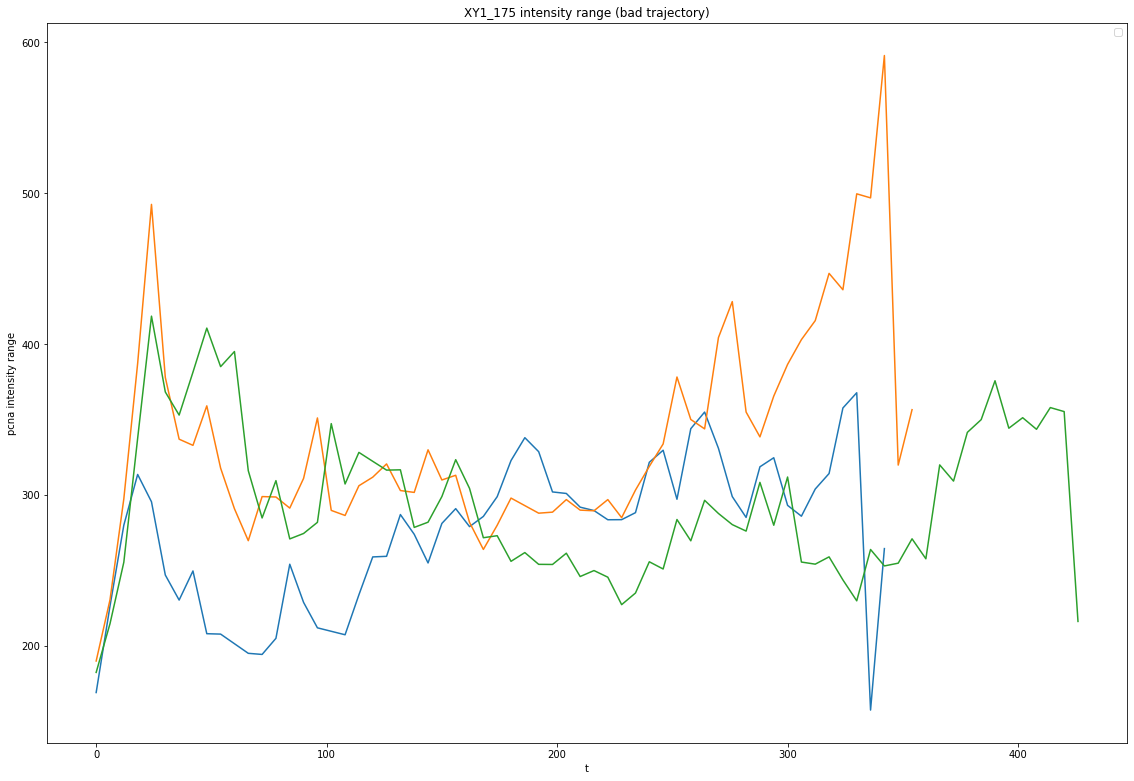

In [13]:
### plot mean intensity for all trajectories (cull if needed) ###
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
for sct_idx in range(len(sct_list)):
    ax.plot(all_traj_zero_init_time[sct_idx],all_traj_pcna_int_range[sct_idx])
    ax.set_title('XY1_175 intensity range (bad trajectory)')
ax.legend()
ax.set_ylabel('pcna intensity range')
ax.set_xlabel('t')
plt.savefig('XY2_196.jpg',bbox_inches='tight', dpi=150)
plt.show()

dtw

In [55]:
### perform dtw(dynamic time warping) on the trajectories (match with best looking one) ###
best_sct_idx = 1
best_sct_t_series = np.matrix.transpose(all_traj_zero_init_time[best_sct_idx])
best_sct_series = np.matrix.transpose(np.vstack((all_traj_pcna_mean_int[best_sct_idx],all_traj_pcna_int_range[best_sct_idx]))) # time series for dtw-mean int, int range

# use the best of 3 trajectories I have now to do dtw on it with other 2, if more than 3 total change the code
layer_1_dtw_t_series = []
layer_1_dtw_sct_series = []
for sct_idx in range(len(sct_list)):
    if sct_idx != best_sct_idx:

        curr_t_series = np.matrix.transpose(all_traj_zero_init_time[sct_idx])
        curr_series = np.matrix.transpose(np.vstack((all_traj_pcna_mean_int[sct_idx],all_traj_pcna_int_range[sct_idx])))
        curr_alignment = dtw_path(curr_series, best_sct_series)[0]

        curr_dtw_t_series = []
        curr_dtw_sct_series = []
        for dtw_traj_idx in range(len(curr_alignment)):
            
            current_curr_t = curr_t_series[curr_alignment[dtw_traj_idx][0]]
            current_best_t = best_sct_t_series[curr_alignment[dtw_traj_idx][1]]
            current_curr_mean_int = curr_series[curr_alignment[dtw_traj_idx][0]][0]
            current_best_mean_int = best_sct_series[curr_alignment[dtw_traj_idx][1]][0]
            current_curr_int_range = curr_series[curr_alignment[dtw_traj_idx][0]][1]
            current_best_int_range = best_sct_series[curr_alignment[dtw_traj_idx][1]][1]

            curr_dtw_t_series.append(np.mean([current_curr_t,current_best_t]))
            curr_dtw_sct_series.append([np.mean([current_curr_mean_int,current_best_mean_int]), \
                np.mean([current_curr_int_range,current_best_int_range])])

        layer_1_dtw_t_series.append(curr_dtw_t_series)
        layer_1_dtw_sct_series.append(curr_dtw_sct_series)

# combine the 2 to form model trajectory
model_traj_t_series = []
model_traj_stats = []
model_traj_alignment = dtw_path(np.array(layer_1_dtw_sct_series[0]), np.array(layer_1_dtw_sct_series[1]))[0]

for dtw_traj_idx in range(len(model_traj_alignment)):

            curr_traj1_t = np.array(layer_1_dtw_t_series[0])[model_traj_alignment[dtw_traj_idx][0]]
            curr_traj2_t = np.array(layer_1_dtw_t_series[1])[model_traj_alignment[dtw_traj_idx][1]]
            curr_traj1_mean_int = np.array(layer_1_dtw_sct_series[0])[model_traj_alignment[dtw_traj_idx][0]][0]
            curr_traj2_mean_int = np.array(layer_1_dtw_sct_series[1])[model_traj_alignment[dtw_traj_idx][1]][0]
            curr_traj1_int_range = np.array(layer_1_dtw_sct_series[0])[model_traj_alignment[dtw_traj_idx][0]][1]
            curr_traj2_int_range = np.array(layer_1_dtw_sct_series[1])[model_traj_alignment[dtw_traj_idx][1]][1]

            model_traj_t_series.append(np.mean([curr_traj1_t,curr_traj2_t]))
            model_traj_stats.append([np.mean([curr_traj1_mean_int,curr_traj2_mean_int]), \
                np.mean([curr_traj1_int_range,curr_traj2_int_range])])

model_traj_t_series = np.array(model_traj_t_series)           
model_traj_stats = np.array(model_traj_stats)

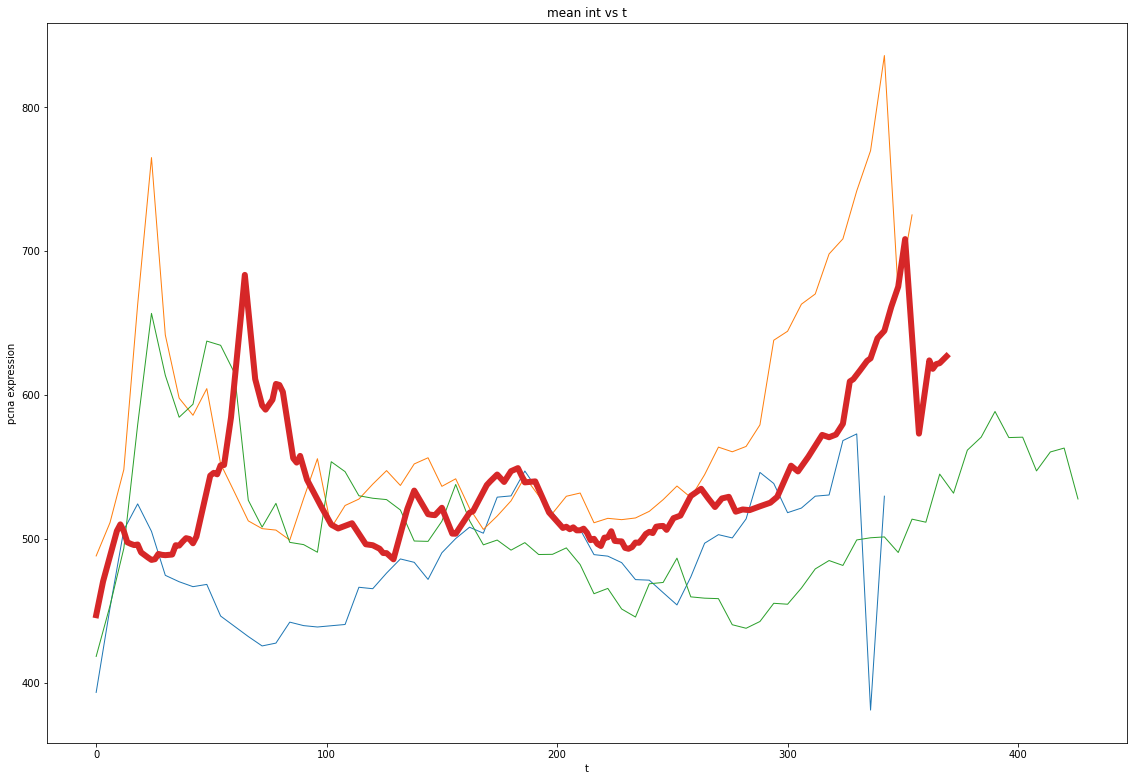

In [50]:
### plot results of dtw - mean int t series###

# plot mean int of all other intact traj
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title('mean int vs t')
for sct_idx in range(len(sct_list)):
    ax.plot(all_traj_zero_init_time[sct_idx],all_traj_pcna_mean_int[sct_idx], linewidth=1)

#plot mean int of model trajectory
ax.plot(model_traj_t_series,model_traj_stats[:,0], linewidth=6)

ax.set_ylabel('pcna expression')
ax.set_xlabel('t')
# plt.savefig('XY2_196.jpg',bbox_inches='tight', dpi=150)
plt.show()


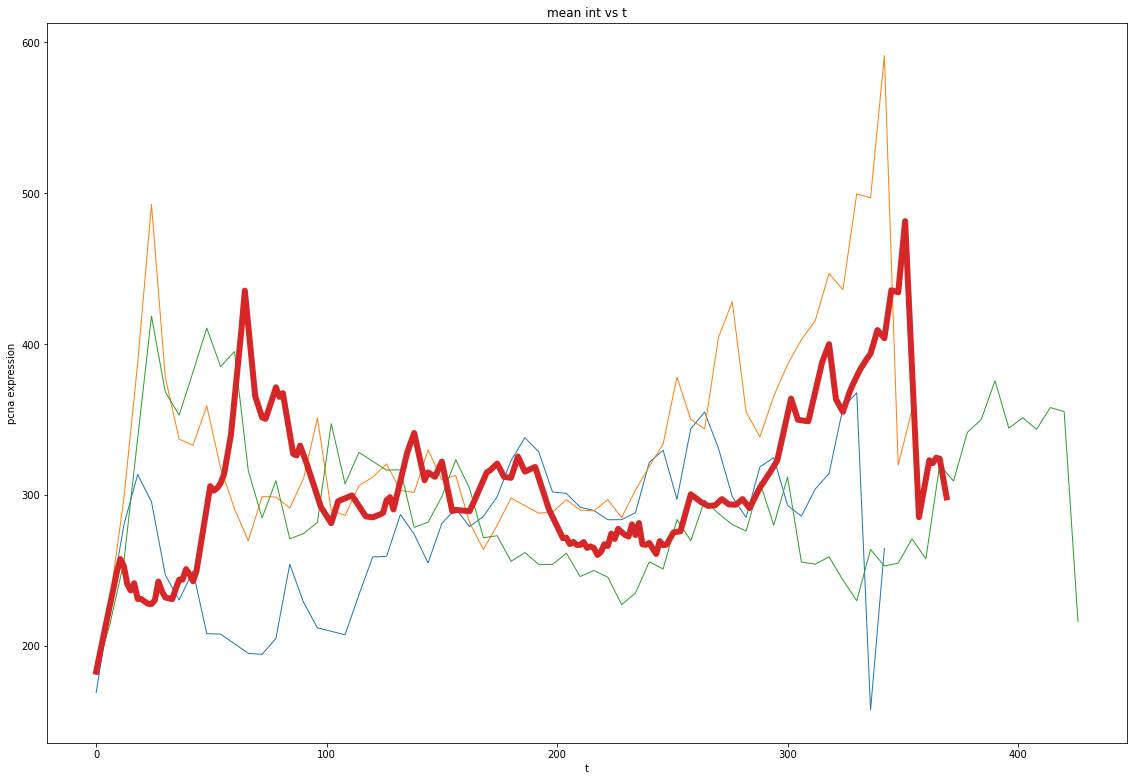

In [51]:
### plot results of dtw -int range t series###

# plot mean int of all other intact traj
fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title('mean int vs t')
for sct_idx in range(len(sct_list)):
    ax.plot(all_traj_zero_init_time[sct_idx],all_traj_pcna_int_range[sct_idx], linewidth=1)

#plot mean int of model trajectory
ax.plot(model_traj_t_series,model_traj_stats[:,1], linewidth=6)

ax.set_ylabel('pcna expression')
ax.set_xlabel('t')
# plt.savefig('XY2_196.jpg',bbox_inches='tight', dpi=150)
plt.show()

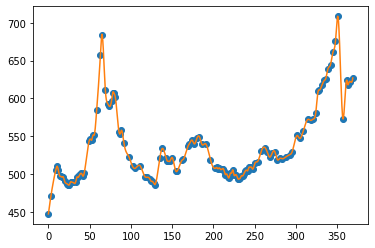

In [77]:
### interpolate the combined intact trajectory to amplify the number of points it has ###
model_traj_t_series_interp = np.linspace(np.min(model_traj_t_series),np.max(model_traj_t_series),100*len(model_traj_t_series))
model_traj_mean_int_interp = interp1d(model_traj_t_series,model_traj_stats[:,0],kind='cubic')
model_traj_int_range_interp = interp1d(model_traj_t_series,model_traj_stats[:,1],kind='cubic')

plt.plot(model_traj_t_series,model_traj_stats[:,0],'o')
plt.plot(model_traj_t_series_interp,model_traj_mean_int_interp(model_traj_t_series_interp),'-')

In [79]:
### save model trajectory ###
model_traj_all_stats = np.vstack((model_traj_t_series_interp,\
    model_traj_mean_int_interp(model_traj_t_series_interp),\
    model_traj_int_range_interp(model_traj_t_series_interp)))
model_traj_all_stats_df = pd.DataFrame(model_traj_all_stats)
stat_labels = ['time','mean_int','int_range']
model_traj_all_stats_df.insert(0,'traj_value',stat_labels)
model_traj_all_stats_df.to_csv(output_path+'traj/model_traj_stats.csv')